In [1]:
import sys, os; sys.path.append('..')
import pyzx as zx
import random
import math
from fractions import Fraction
%config InlineBackend.figure_format = 'svg'

In [38]:
g = zx.Circuit.load('../circuits/Fast/hwb6.qc').to_graph()
zx.d3.draw(g)
print(zx.tcount(g))

105


In [19]:
def generate_random_graph(verts, gadget_prob, edge_prob):
    vs = []
    gs = []
    g = zx.Graph()
    for _ in range(verts):
        phase = Fraction(2*random.randint(0,3)+1,4)
        if random.random() < gadget_prob:
            v1 = g.add_vertex(1,-2, len(gs),phase)
            v2 = g.add_vertex(1,-1,len(gs),0)
            g.add_edge((v1,v2),2)
            gs.append(v2)
        else:
            v = g.add_vertex(1,random.randint(0,verts/4),random.randint(0,int(verts*(1-gadget_prob))),phase)
            vs.append(v)
    
    edges = []
    for i in range(len(vs)):
        v1 = vs[i]
        for j in range(i+1,len(vs)):
            v2 = vs[j]
            if random.random() < edge_prob:
                edges.append((v1,v2))
        for v2 in gs:
            if random.random() < edge_prob:
                edges.append((v1,v2))
    g.add_edges(edges,2)
    return g

In [56]:
g = generate_random_graph(20,0.5,0.3)
print(zx.tcount(g))
zx.simplify.reduce_scalar(g)
print(zx.tcount(g))
zx.d3.draw(g)

20
20


In [79]:
def generate_data(verts,gadget_prob, edge_prob, repeats):
    totalscore = 0
    scores = []
    for _ in range(repeats):
        g = generate_random_graph(verts, gadget_prob, edge_prob)
        zx.simplify.reduce_scalar(g)
        best = -1
        for _ in range(200):
            gsum = zx.simulate.replace_magic_states(g, pick_random=True)
            gsum.reduce_scalar()
            approx_terms = sum(math.ceil(2**(0.468 * zx.tcount(h))) for h in gsum.graphs)
            if best == -1 or best > approx_terms:
                best = approx_terms
        totalscore += best
        scores.append(best)
    return totalscore / repeats, scores

In [95]:
probs = [0.07*i for i in range(3,11)]
probs[-1] = 0.7

In [88]:
# random.seed(42)
# probs = [0.07*i for i in range(3,10)]

# xs = []
# ys = []
# verts = 40
# gadget_prob = 0.5
for edge_prob in probs:
    print(edge_prob, end='. ')
    score, scores = generate_data(verts,gadget_prob, edge_prob, 15)
    for score in scores:
        xs.append(edge_prob)
        ys.append(score)
    #ys.append(score)

0.7. 

In [96]:
av_x = {p:list() for p in probs}
for x, y in zip(xs,ys):
    av_x[x].append(y)

av_y = [sum(yy)/len(yy) for yy in av_x.values()]
av_y

[214386.66666666666,
 297732.86666666664,
 323586.4,
 318879.73333333334,
 402176.0,
 403512.93333333335,
 353891.73333333334,
 394526.2]

In [67]:
%matplotlib inline
import matplotlib.pyplot as plt
#from sklearn.linear_model import LinearRegression
plt.style.use('seaborn-whitegrid')
colours = ['#53257f', '#bc1b73', '#f8534a', '#ffa600']
names = ['original','original+','naive', 'pyzx']
styles = ['-','--','-.',':']

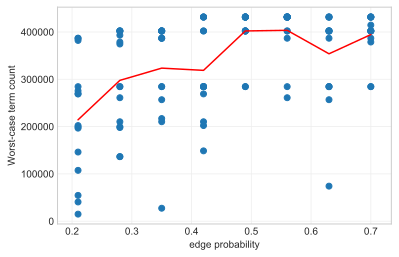

In [97]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
#ax1.plot(xs, ys, c=colours[0], marker="o",markersize=3, linestyle=styles[0], label=names[0])
ax1.scatter(xs,ys)
ax1.plot(probs, av_y, color='r')
ax1.set_ylabel("Worst-case term count")
ax1.set_xlabel("edge probability")
#plt.legend(loc='upper left');
plt.grid(color='#EEEEEE')
plt.show()

In [69]:
math.ceil(2**(0.468 * 40))

431799

In [2]:
random.seed(1337)
c = zx.generate.CNOT_HAD_PHASE_circuit(20, 500, 0.03, 0.1)
g = c.to_graph()
zx.simplify.full_reduce(g)
g.normalise()
print(zx.tcount(g))
state = "".join([random.sample("01+-",1)[0] for _ in range(len(g.inputs))])
effect = "".join([random.sample("01+-",1)[0] for _ in range(len(g.outputs))])
g.apply_state(state)
g.apply_effect(effect)
zx.simplify.full_reduce(g)
zx.simplify.reduce_scalar(g)
print(zx.tcount(g))
zx.drawing.arrange_scalar_diagram(g)
zx.d3.draw(g)

38
29


In [39]:
zx.simplify.full_reduce(g)
zx.d3.draw(g)
print(zx.tcount(g))

75


In [40]:
g.apply_state("++---+-")
g.apply_effect("+011-1-")
zx.simplify.full_reduce(g)
print(zx.tcount(g))
zx.drawing.arrange_scalar_diagram(g)
zx.d3.draw(g)

33


In [4]:
def decomp_search(g, depth=0, num_tries=600):
    if zx.tcount(g) >= 6:
        prev_best = -1
        prev_best_gsum = None
        tries = 0
        total_tries = 0
        while True:
            total_tries += 1
            if total_tries % 100 == 0: print(total_tries)
            gsum = zx.simulate.replace_magic_states(g, pick_random=True)
            gsum.reduce_scalar()
            approx_terms = sum(math.ceil(2**(0.468 * zx.tcount(h))) for h in gsum.graphs)
            if prev_best == -1 or prev_best > approx_terms:
                prev_best = approx_terms
                prev_best_gsum = gsum
                print("Depth", depth, "New best:", [zx.tcount(h) for h in gsum.graphs])
                tries = 1
            else:
                tries += 1
            if tries >= num_tries:
                break
        gsum = prev_best_gsum
        vals = 0
        terms = 0
        for g1 in gsum.graphs:
            t,tt,v = decomp_search(g1, depth+1, num_tries=math.ceil(num_tries/2))
            terms += t
            total_tries += tt
            vals += v
        return (terms, total_tries, vals)
    else:
        return (2 ** math.ceil(zx.tcount(g)/2), 1, g.to_matrix())

Expected summands for s.o.t.a. exact decomposition and approximate decomposition with norm distance $< 0.1$.

In [7]:
(math.ceil(2**(0.468 * zx.tcount(g))), math.ceil(((0.1)**(-2))*2**(0.228 * zx.tcount(g))))

(12179, 9782)

In [5]:
random.seed(400)
print(decomp_search(g, num_tries=600))

Depth 0 New best: [23, 23, 23, 23, 19, 23, 23]
Depth 0 New best: [23, 23, 23, 23, 16, 23, 23]
Depth 0 New best: [23, 23, 21, 21, 21, 21, 21]
Depth 0 New best: [23, 23, 21, 21, 17, 21, 21]
100
Depth 0 New best: [23, 23, 20, 20, 18, 20, 20]
200
300
400
500
600
700
Depth 1 New best: [17, 17, 17, 17, 15, 17, 17]
Depth 1 New best: [17, 17, 17, 17, 14, 17, 17]
Depth 1 New best: [17, 17, 17, 17, 12, 17, 17]
Depth 1 New best: [17, 17, 16, 16, 16, 16, 16]
Depth 1 New best: [17, 17, 15, 15, 13, 15, 15]
100
200
300
Depth 2 New best: [11, 11, 11, 11, 11, 11, 11]
Depth 2 New best: [11, 9, 11, 11, 11, 11, 11]
Depth 2 New best: [9, 9, 11, 11, 11, 11, 11]
Depth 2 New best: [11, 11, 9, 9, 9, 11, 11]
Depth 2 New best: [11, 11, 8, 8, 9, 10, 11]
Depth 2 New best: [11, 11, 9, 9, 9, 7, 9]
100
200
Depth 3 New best: [0, 5, 0, 0, 5, 5, 0]
Depth 3 New best: [0, 4, 0, 0, 5, 0, 5]
Depth 3 New best: [5, 0, 3, 3, 0, 0, 0]
Depth 3 New best: [0, 0, 0, 0, 0, 0, 5]
Depth 3 New best: [0, 3, 0, 0, 0, 0, 0]
100
Depth 3 Ne

Depth 2 New best: [0, 6, 0, 0, 6, 6, 0]
Depth 2 New best: [0, 6, 0, 0, 5, 3, 5]
Depth 2 New best: [0, 6, 0, 0, 4, 0, 4]
Depth 2 New best: [0, 6, 0, 0, 0, 3, 0]
100
Depth 2 New best: [0, 0, 4, 3, 0, 0, 0]
Depth 2 New best: [0, 4, 0, 0, 0, 0, 0]
200
300
Depth 2 New best: [5, 5, 6, 6, 6, 6, 0]
Depth 2 New best: [0, 6, 0, 6, 6, 6, 6]
Depth 2 New best: [0, 6, 6, 6, 5, 0, 5]
Depth 2 New best: [3, 3, 6, 6, 6, 3, 0]
Depth 2 New best: [0, 4, 0, 3, 0, 5, 0]
Depth 2 New best: [0, 0, 0, 0, 4, 0, 0]
100
Depth 2 New best: [4, 0, 0, 4, 4, 6, 6]
Depth 2 New best: [4, 4, 0, 5, 0, 6, 0]
Depth 2 New best: [0, 0, 6, 6, 4, 0, 0]
Depth 2 New best: [3, 0, 6, 0, 0, 0, 0]
Depth 2 New best: [0, 0, 0, 0, 0, 0, 4]
100
Depth 2 New best: [5, 5, 4, 4, 0, 0, 5]
Depth 2 New best: [5, 0, 4, 4, 0, 0, 5]
Depth 2 New best: [5, 0, 0, 0, 0, 0, 0]
Depth 2 New best: [0, 0, 0, 0, 0, 4, 0]
Depth 2 New best: [0, 0, 0, 0, 0, 0, 3]
100
Depth 2 New best: [0, 0, 0, 0, 0, 0, 0]
200
Depth 2 New best: [6, 6, 6, 6, 0, 6, 5]
Depth 2 New 

In [13]:
random.seed(400)
print(decomp_search(g, num_tries = 200))
random.seed(500)
print(decomp_search(g, num_tries = 100))

Depth 0 New best: [27, 27, 27, 27, 19, 27, 27]
Depth 0 New best: [27, 27, 27, 27, 8, 27, 27]
Depth 0 New best: [27, 27, 27, 27, 0, 27, 27]
Depth 0 New best: [27, 27, 21, 23, 0, 21, 21]
Depth 0 New best: [27, 27, 15, 15, 0, 0, 15]
Depth 1 New best: [21, 21, 21, 21, 16, 21, 21]
Depth 1 New best: [21, 21, 21, 21, 14, 21, 21]
Depth 1 New best: [21, 21, 21, 21, 9, 21, 21]
Depth 1 New best: [19, 19, 13, 13, 11, 21, 21]
Depth 1 New best: [21, 21, 13, 13, 0, 19, 19]
Depth 1 New best: [19, 19, 6, 10, 0, 19, 19]
Depth 2 New best: [13, 13, 13, 13, 0, 13, 13]
Depth 2 New best: [13, 13, 11, 11, 0, 11, 11]
Depth 3 New best: [7, 7, 7, 0, 4, 7, 7]
Depth 3 New best: [7, 7, 0, 5, 4, 5, 7]
Depth 3 New best: [0, 0, 7, 5, 7, 0, 6]
Depth 3 New best: [0, 7, 5, 4, 0, 5, 5]
Depth 4 New best: [0, 0, 0, 0, 0, 0, 0]
Depth 3 New best: [6, 6, 0, 0, 0, 7, 7]
Depth 3 New best: [6, 4, 0, 7, 6, 0, 0]
Depth 3 New best: [0, 0, 0, 0, 3, 7, 6]
Depth 3 New best: [0, 4, 0, 0, 0, 7, 4]
Depth 4 New best: [0, 0, 0, 0, 0, 1, 0]


Depth 2 New best: [15, 15, 13, 13, 0, 13, 13]
Depth 2 New best: [15, 15, 12, 12, 3, 13, 13]
Depth 2 New best: [15, 15, 12, 12, 10, 12, 12]
Depth 3 New best: [8, 8, 9, 9, 7, 9, 7]
Depth 3 New best: [9, 9, 7, 7, 5, 9, 0]
Depth 4 New best: [0, 0, 0, 0, 0, 0, 0]
Depth 4 New best: [0, 3, 0, 0, 0, 0, 3]
Depth 4 New best: [0, 0, 0, 0, 0, 0, 0]
Depth 4 New best: [0, 0, 0, 0, 0, 0, 0]
Depth 4 New best: [0, 0, 0, 0, 0, 0, 0]
Depth 4 New best: [0, 0, 3, 3, 0, 0, 0]
Depth 4 New best: [0, 0, 0, 0, 0, 0, 0]
Depth 3 New best: [9, 9, 0, 0, 3, 9, 7]
Depth 4 New best: [3, 3, 3, 0, 0, 0, 0]
Depth 4 New best: [0, 0, 0, 0, 0, 0, 3]
Depth 4 New best: [0, 0, 0, 0, 0, 0, 0]
Depth 4 New best: [3, 3, 3, 0, 0, 3, 0]
Depth 4 New best: [0, 0, 0, 0, 0, 3, 3]
Depth 4 New best: [0, 0, 0, 3, 0, 0, 0]
Depth 4 New best: [0, 0, 0, 0, 0, 0, 0]
Depth 4 New best: [0, 0, 0, 0, 0, 0, 0]
Depth 4 New best: [0, 0, 0, 0, 0, 0, 0]
Depth 3 New best: [0, 4, 4, 4, 0, 4, 0]
Depth 3 New best: [6, 6, 4, 6, 0, 6, 0]
Depth 3 New best: [4,

Depth 3 New best: [0, 0, 0, 0, 0, 3, 0]
Depth 3 New best: [0, 0, 0, 0, 0, 0, 0]
Depth 3 New best: [5, 5, 7, 7, 0, 6, 7]
Depth 3 New best: [7, 7, 0, 0, 6, 7, 7]
Depth 3 New best: [7, 7, 3, 3, 0, 7, 7]
Depth 3 New best: [6, 6, 5, 7, 0, 0, 5]
Depth 4 New best: [0, 0, 0, 0, 0, 0, 0]
Depth 4 New best: [0, 0, 0, 0, 0, 0, 0]
Depth 4 New best: [0, 0, 0, 0, 0, 0, 0]
Depth 3 New best: [9, 9, 5, 7, 5, 9, 9]
Depth 3 New best: [5, 0, 6, 6, 7, 5, 9]
Depth 4 New best: [0, 0, 0, 0, 0, 0, 0]
Depth 4 New best: [0, 0, 0, 0, 0, 0, 0]
Depth 4 New best: [0, 0, 0, 0, 0, 0, 0]
Depth 4 New best: [0, 0, 0, 0, 0, 0, 0]
Depth 2 New best: [15, 15, 12, 9, 0, 6, 15]
Depth 3 New best: [7, 9, 9, 9, 0, 8, 9]
Depth 3 New best: [5, 5, 0, 0, 5, 3, 7]
Depth 4 New best: [0, 0, 0, 0, 0, 0, 0]
Depth 3 New best: [7, 7, 9, 9, 6, 9, 9]
Depth 3 New best: [9, 9, 6, 6, 6, 9, 9]
Depth 3 New best: [9, 9, 7, 7, 5, 7, 6]
Depth 3 New best: [9, 9, 5, 5, 7, 0, 8]
Depth 3 New best: [7, 7, 0, 7, 0, 0, 9]
Depth 3 New best: [7, 7, 5, 4, 0, 7,

Depth 4 New best: [0, 0, 0, 0, 0, 0, 0]
Depth 3 New best: [5, 5, 6, 6, 0, 4, 6]
Depth 3 New best: [5, 5, 6, 0, 0, 6, 6]
Depth 3 New best: [0, 0, 6, 6, 0, 5, 6]
Depth 3 New best: [0, 3, 0, 3, 0, 0, 3]
Depth 3 New best: [0, 0, 0, 5, 0, 4, 0]
Depth 3 New best: [0, 0, 3, 0, 0, 0, 0]
Depth 3 New best: [0, 0, 0, 0, 0, 0, 0]
Depth 3 New best: [3, 3, 0, 0, 0, 0, 5]
Depth 3 New best: [0, 0, 0, 0, 0, 0, 0]
Depth 3 New best: [0, 0, 5, 5, 0, 5, 0]
Depth 3 New best: [0, 0, 5, 5, 0, 0, 0]
Depth 3 New best: [0, 0, 0, 0, 0, 5, 0]
Depth 3 New best: [0, 4, 0, 0, 0, 0, 0]
Depth 3 New best: [0, 0, 0, 0, 0, 0, 3]
Depth 3 New best: [0, 0, 0, 0, 0, 0, 0]
Depth 2 New best: [9, 9, 9, 9, 6, 9, 9]
Depth 2 New best: [9, 9, 5, 3, 0, 9, 9]
Depth 2 New best: [8, 8, 0, 0, 0, 7, 9]
Depth 2 New best: [4, 4, 0, 0, 8, 7, 4]
Depth 3 New best: [0, 0, 0, 0, 0, 0, 0]
Depth 3 New best: [0, 0, 0, 0, 0, 0, 0]
Depth 2 New best: [9, 9, 9, 9, 0, 9, 9]
Depth 2 New best: [7, 7, 9, 9, 7, 7, 9]
Depth 2 New best: [6, 6, 0, 0, 0, 9, 9]


In [6]:
zx.simulate.calculate_path_sum(g)

(-0.0003496046180028148-0.0005493164062500222j)

In [95]:
math.log(math.cos(math.pi / 8)**-2, 2)

0.22844669683638807

In [98]:
def eff(x,y): return math.log(y,2)/x

In [100]:
[eff(x,y) for x,y in [(1,2),(2,3),(3,4),(4,5),(5,6),(6,8),(7,14)]]

[1.0,
 0.7924812503605781,
 0.6666666666666666,
 0.5804820237218405,
 0.5169925001442313,
 0.5,
 0.5439078460082291]